In [1]:
import numpy as np
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

import utils_ext
import train_utils_ext
import network


torch.manual_seed(55)

%reload_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
                    'axes.labelsize': 28.0,
                    'grid.alpha': 0.6,
                    'legend.framealpha': 0.6,
                    "text.usetex": True,
                    "font.family": "serif",
                    'figure.figsize': [15,6],
                    "font.size": 28,
                    "hatch.linewidth": 0.0,
                    "hatch.color": (0,0,0,0.0),
                    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
                    })

### Load train, validation and test dataset and create Data Loader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

Using cuda device


In [5]:
print(f"Number of elements in train set: {len(train_dataset)}.")
print(f"Number of elements in valid set:  {len(val_dataset)}.")
print(f"Number of elements in test set:   {len(test_dataset)}.")

Number of elements in train set: 935.
Number of elements in valid set:  88.
Number of elements in test set:   89.


## Plot some examples

In [6]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:np.eye(len(ACTIVITIES))[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {tuple(v): k for k, v in class_enc.items()}
class_dec

{(1.0, 0.0, 0.0, 0.0): 'WALKING',
 (0.0, 1.0, 0.0, 0.0): 'RUNNING',
 (0.0, 0.0, 1.0, 0.0): 'SITTING',
 (0.0, 0.0, 0.0, 1.0): 'HANDS'}

In [4]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

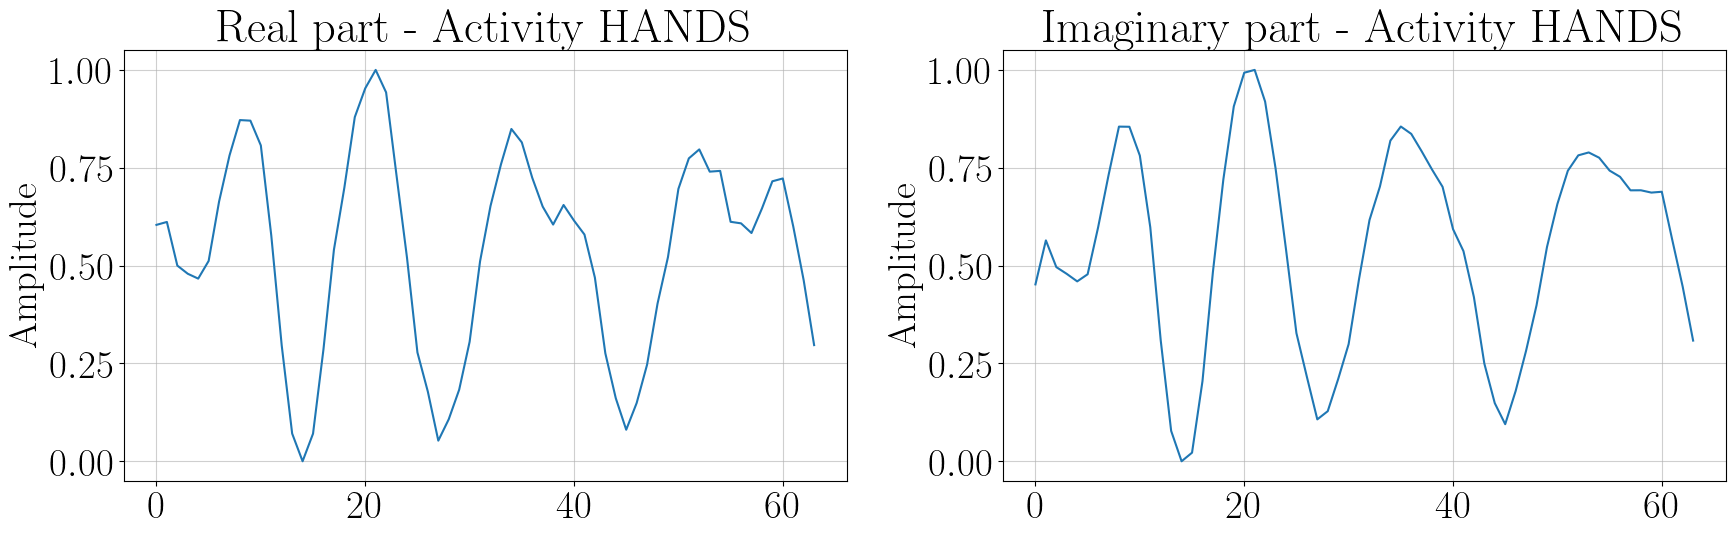

CIR shape: torch.Size([2, 232, 10, 64])


In [165]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0], train_dataset[i][2]

fig, ax = plt.subplots(1, 2, figsize=(18,6))

plt.subplot(121)
plt.plot(X[0,0,0,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Real part - Activity {class_dec[int(Y)]}")
plt.grid()

plt.subplot(122)
plt.plot(X[0,0,1,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Imaginary part - Activity {class_dec[int(Y)]}")
plt.grid()
plt.tight_layout()

#plt.savefig('Signal_example1.png')
plt.show()

print(f"CIR shape: {X.shape}")

The CIR has shape ($N$, $R$, $2$, $K$), where:

- $N$ is the number of windows;
- $R$ is the number of range bins, in this case: $R=10$;
- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $K$ is the length of each windows, in this case: $K=64$.

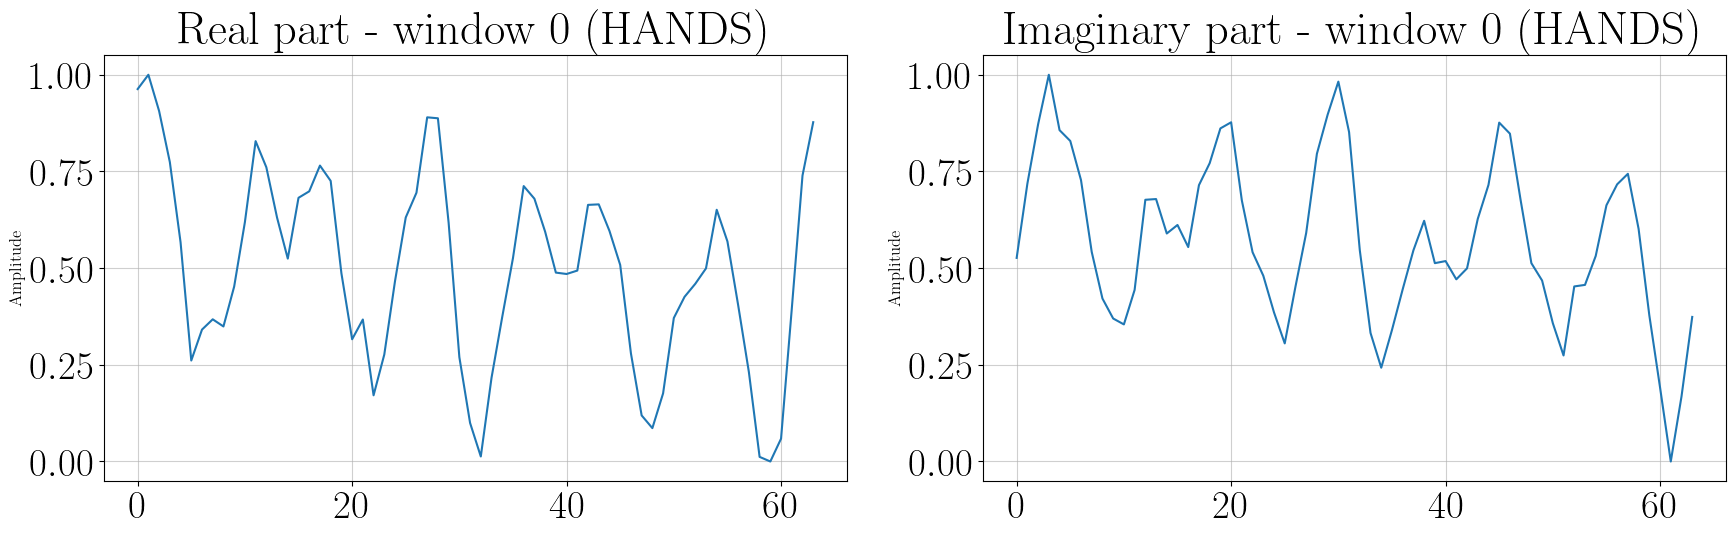

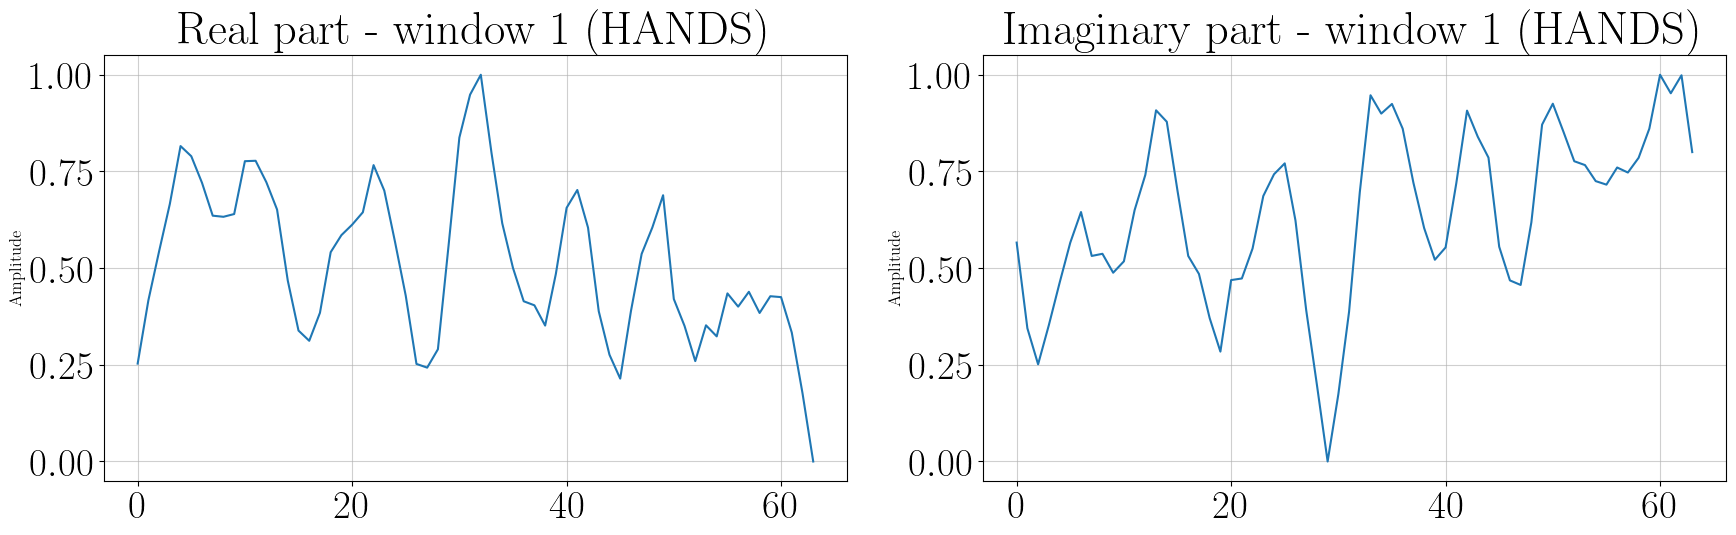

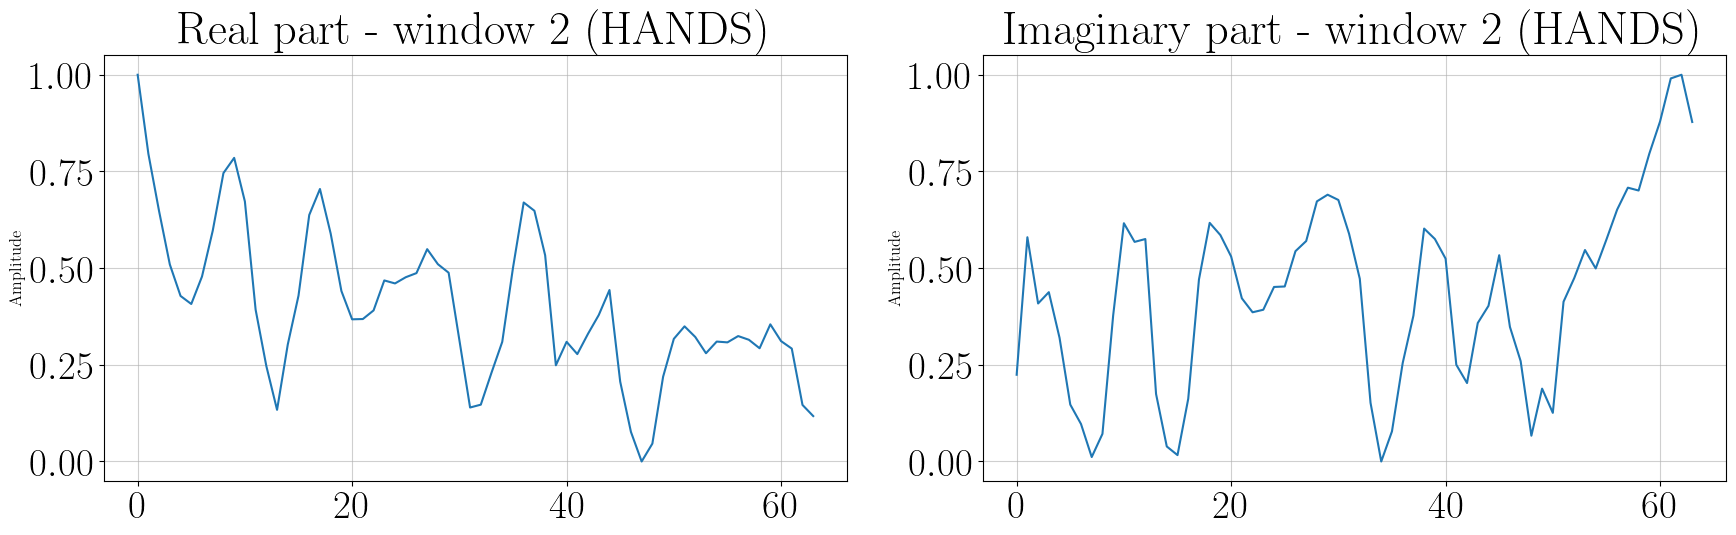

In [166]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

In [167]:
for batch, X in enumerate(train_loader):
    print(X[0].shape)
    print(X[2].shape)
    break

torch.Size([32, 2, 232, 10, 64])
torch.Size([32, 1])


### Input correlation

In [7]:
corr_input = []

for X, _, _ in tqdm.tqdm(train_dataset):

    for w in range(X.shape[1]):
        for b in range(X.shape[2]):

            corr_input.append(np.corrcoef(X[0][w][b], X[1][w][b])[0,1])

  0%|          | 0/935 [00:00<?, ?it/s]

100%|██████████| 935/935 [02:11<00:00,  7.12it/s]


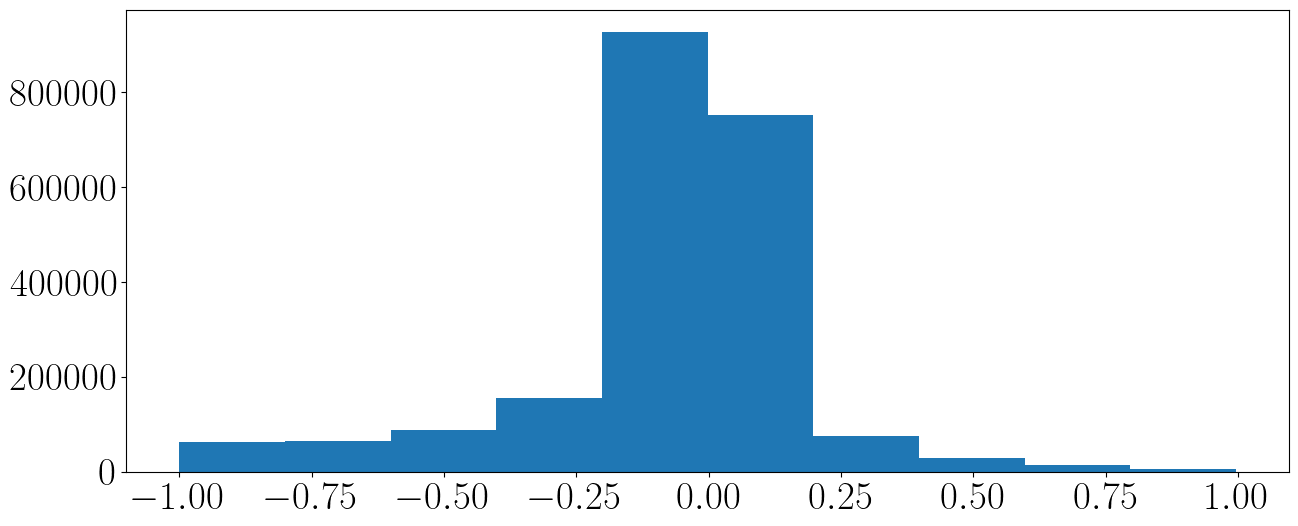

In [8]:
plt.hist(corr_input)
plt.show()

## Hyperparameter optimization

In [5]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()

        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        #print(encoded.shape)
        clss = self.snn(encoded)
        #print("Class: ", clss.shape)
        
        return encoded, decoded, clss

### 1. # Conv. layers in the CAE

In [18]:
params_train = {
                "epochs": 25,
                "acc_steps": None,
                "l_rate": 1e-3,
                "lambda_reg": 0.0,
                "alpha": 1,
                "beta": 1,
                "patience": 100,
                }

params_cae = {
                "kernel": (1,1,3),
                "feature_maps": [64,32],
                "theta": 0.5,
                "loss_fn": torch.nn.MSELoss(),
    
}

params_snn = {
                "hidden_layers": [16,1],
                "num_classes": 4,
                "surrogate_grad": surrogate.atan(),
                "output_decoding": "rate",
                "loss_fn": SF.ce_rate_loss() #ce_temporal_loss()

}

In [ ]:
val_mse_layers = []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = [16, 1], 
                    n_classes = num_act, 
                    surr_grad = surrogate.atan(), 
                    learn_thr=True, learn_beta = True
                    ).to(device)

# CAE with 2 layers
autoencoder = network.cae_2(
                            theta=theta_ , channels=out_channels, 
                            kernel_size=kernel, 
                            stride = 1, padding=[0,0,1]
                            ).to(device)

net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss, cae_loss, snn_loss = train_utils_ext.train(
                                                    model=net, 
                                                    train=train_loader, valid=val_loader,
                                                    loss_fn_cae=loss_cae, out_dec=out_dec,
                                                    optimizer=optimizer, acc_steps=acc_steps,
                                                    alfa=alfa, beta=beta, Lambda=lambda_reg, 
                                                    epochs=epochs, patience=patience, 
                                                    path=None)

val_mse_layers.append(np.mean(val_loss))

autoencoder = autoencoder.cpu()
net = net.cpu()

del autoencoder, optimizer, net
torch.cuda.empty_cache()

# CAE with 3 layers
autoencoder = network.cae_3(
                            theta=theta_, channels=out_channels, 
                            kernel_size=kernel, 
                            stride=1, padding=[0,0,1]
                            ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss1, val_loss1, cae_loss1, snn_loss1 = train_utils_ext.train(
                                                        model=net, 
                                                        train=train_loader, valid=val_loader,
                                                        loss_fn_cae=loss_cae, out_dec=out_dec,
                                                        optimizer=optimizer, acc_steps=acc_steps,
                                                        alfa=alfa, beta=beta, Lambda=lambda_reg, 
                                                        epochs=epochs, patience=patience, 
                                                        path=None)
val_mse_layers.append(np.mean(val_loss1))

In [11]:
val_mse_layers = []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = [16, 1], 
                    n_classes = num_act, 
                    surr_grad = surrogate.atan(), 
                    learn_thr=True, learn_beta = True
                    ).to(device)

# CAE with 2 layers
autoencoder = network.cae_2(
                            theta=theta_ , channels=out_channels, 
                            kernel_size=kernel, 
                            stride = 1, padding=[0,0,1]
                            ).to(device)

net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                    model=net, 
                                                    train=train_loader, valid=val_loader,
                                                    loss_fn_cae=loss_cae, out_dec=out_dec,
                                                    optimizer=optimizer, acc_steps=acc_steps,
                                                    alfa=alfa, beta=beta, Lambda=lambda_reg, 
                                                    epochs=epochs, patience=patience, 
                                                    path=None)

val_mse_layers.append(np.mean(val_loss))

autoencoder = autoencoder.cpu()
net = net.cpu()

  4%|▍         | 1/25 [04:11<1:40:36, 251.51s/it]

Epoch 1 - loss: 1.4253 | acc: 0.3974 | val_loss: 1.414 | val_acc: 0.5114


  8%|▊         | 2/25 [08:25<1:37:03, 253.19s/it]

Epoch 2 - loss: 1.4235 | acc: 0.3979 | val_loss: 1.4559 | val_acc: 0.5114


 12%|█▏        | 3/25 [12:40<1:33:01, 253.71s/it]

Epoch 3 - loss: 3.093 | acc: 0.3881 | val_loss: 1.5447 | val_acc: 0.2614


 16%|█▌        | 4/25 [16:54<1:28:48, 253.76s/it]

Epoch 4 - loss: 1.9336 | acc: 0.3872 | val_loss: 1.3477 | val_acc: 0.4432


 20%|██        | 5/25 [21:06<1:24:28, 253.41s/it]

Epoch 5 - loss: 1.2307 | acc: 0.4826 | val_loss: 0.824 | val_acc: 0.5455


 24%|██▍       | 6/25 [25:18<1:20:04, 252.84s/it]

Epoch 6 - loss: 1.0566 | acc: 0.5583 | val_loss: 1.053 | val_acc: 0.6136


 28%|██▊       | 7/25 [29:15<1:14:15, 247.52s/it]

Epoch 7 - loss: 0.9588 | acc: 0.5913 | val_loss: 1.4042 | val_acc: 0.6477


 32%|███▏      | 8/25 [33:11<1:09:07, 243.94s/it]

Epoch 8 - loss: 0.8926 | acc: 0.6065 | val_loss: 0.9537 | val_acc: 0.625


 36%|███▌      | 9/25 [37:09<1:04:34, 242.13s/it]

Epoch 9 - loss: 0.8139 | acc: 0.6468 | val_loss: 0.9228 | val_acc: 0.5341


 40%|████      | 10/25 [41:05<1:00:04, 240.32s/it]

Epoch 10 - loss: 0.8949 | acc: 0.6422 | val_loss: 1.0698 | val_acc: 0.5227


 44%|████▍     | 11/25 [45:03<55:54, 239.58s/it]  

Epoch 11 - loss: 1.2911 | acc: 0.6003 | val_loss: 1.2868 | val_acc: 0.3977


 48%|████▊     | 12/25 [49:01<51:46, 238.97s/it]

Epoch 12 - loss: 1.4971 | acc: 0.6194 | val_loss: 1.5904 | val_acc: 0.2841


 52%|█████▏    | 13/25 [52:56<47:33, 237.81s/it]

Epoch 13 - loss: 2.0051 | acc: 0.6525 | val_loss: 1.6239 | val_acc: 0.6477


 56%|█████▌    | 14/25 [56:51<43:26, 236.98s/it]

Epoch 14 - loss: 1.3668 | acc: 0.7018 | val_loss: 2.2337 | val_acc: 0.7159


 60%|██████    | 15/25 [1:00:48<39:29, 237.00s/it]

Epoch 15 - loss: 1.3067 | acc: 0.7207 | val_loss: 1.3891 | val_acc: 0.6932


 64%|██████▍   | 16/25 [1:04:44<35:29, 236.59s/it]

Epoch 16 - loss: 1.1282 | acc: 0.7028 | val_loss: 1.5376 | val_acc: 0.6705


 68%|██████▊   | 17/25 [1:08:40<31:31, 236.43s/it]

Epoch 17 - loss: 0.9666 | acc: 0.7401 | val_loss: 1.1167 | val_acc: 0.6818


 72%|███████▏  | 18/25 [1:12:35<27:32, 236.13s/it]

Epoch 18 - loss: 0.7669 | acc: 0.7924 | val_loss: 1.6355 | val_acc: 0.6932


 76%|███████▌  | 19/25 [1:16:33<23:39, 236.54s/it]

Epoch 19 - loss: 0.7917 | acc: 0.7885 | val_loss: 1.6469 | val_acc: 0.6705


 80%|████████  | 20/25 [1:20:31<19:45, 237.04s/it]

Epoch 20 - loss: 0.8754 | acc: 0.7636 | val_loss: 1.0914 | val_acc: 0.6818


 84%|████████▍ | 21/25 [1:24:28<15:47, 236.98s/it]

Epoch 21 - loss: 0.7702 | acc: 0.7785 | val_loss: 1.7554 | val_acc: 0.5909


 88%|████████▊ | 22/25 [1:28:24<11:50, 236.89s/it]

Epoch 22 - loss: 0.7036 | acc: 0.7914 | val_loss: 1.5584 | val_acc: 0.5795


 92%|█████████▏| 23/25 [1:32:22<07:54, 237.22s/it]

Epoch 23 - loss: 0.7966 | acc: 0.8011 | val_loss: 3.4639 | val_acc: 0.6705


 96%|█████████▌| 24/25 [1:36:19<03:57, 237.03s/it]

Epoch 24 - loss: 0.7693 | acc: 0.8141 | val_loss: 1.2137 | val_acc: 0.6932


100%|██████████| 25/25 [1:40:14<00:00, 240.59s/it]

Epoch 25 - loss: 0.5697 | acc: 0.8301 | val_loss: 1.2265 | val_acc: 0.6705


In [17]:
model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1932

In [ ]:
print(torch.cuda.memory_summary())

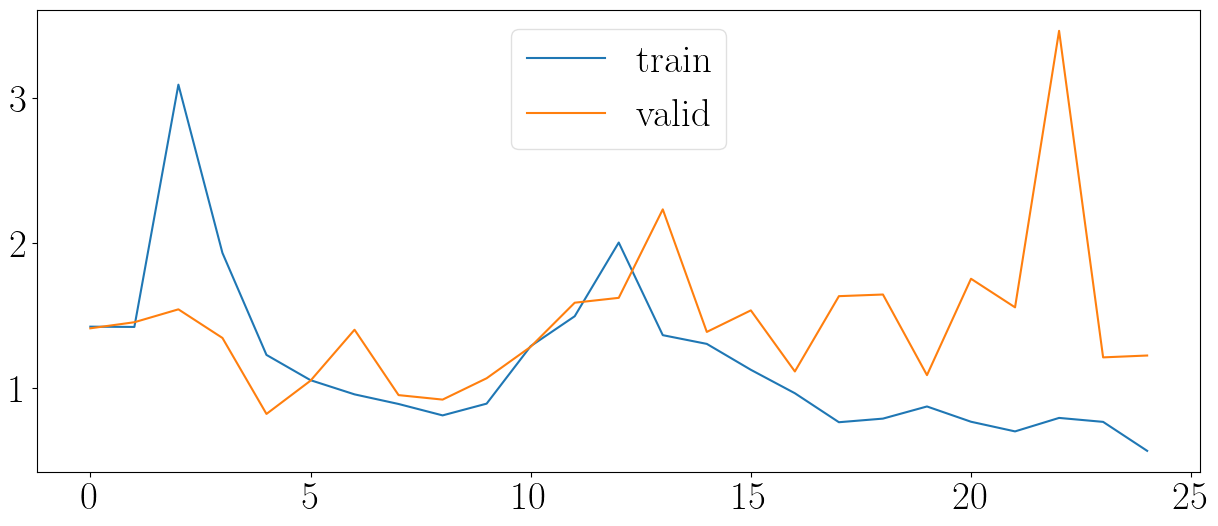

In [12]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

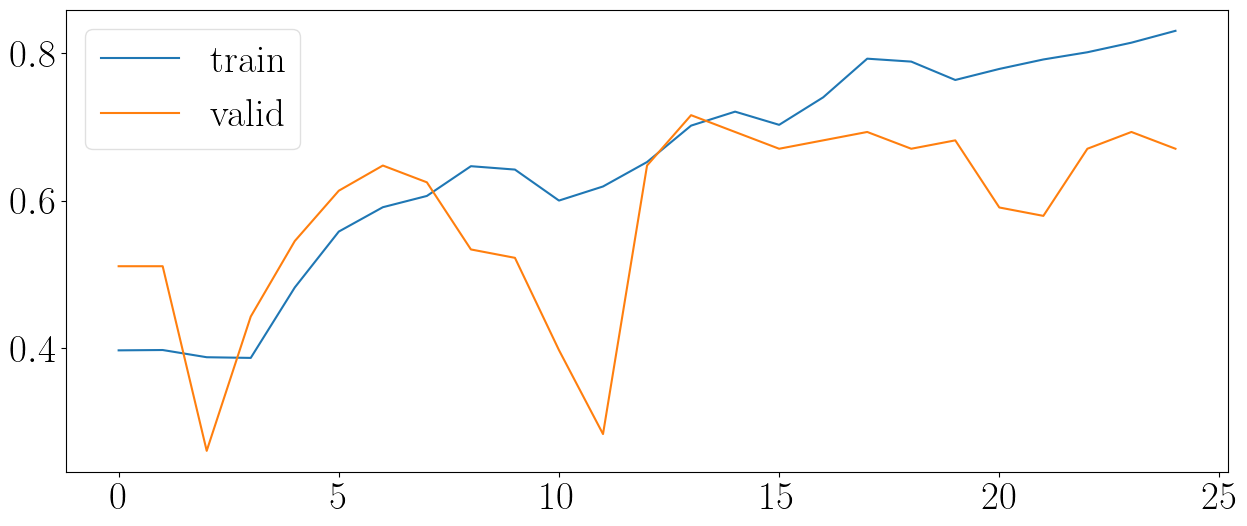

In [13]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

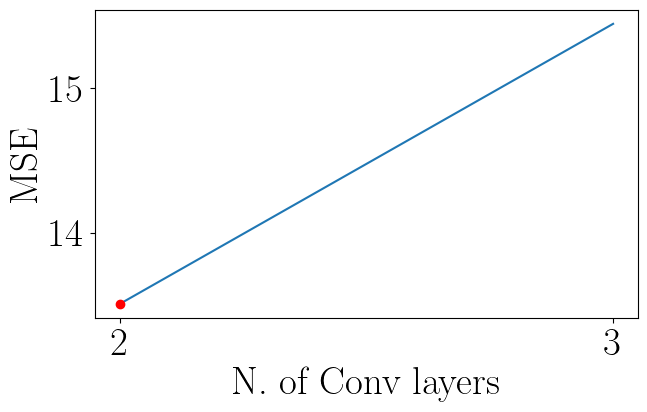

In [21]:
ind_min_nl = np.argmin(val_mse_layers)
plt.figure(figsize=(7,4))
plt.plot(val_mse_layers)
plt.plot(ind_min_nl, val_mse_layers[ind_min_nl], marker='o', color='red')
plt.xticks([0,1], ['2', '3'])
plt.xlabel('N. of Conv layers')
plt.ylabel('MSE')
plt.show()

### 2. Number of channels

In [5]:
eta = 1e-3
lambda_reg = 0.0
channels = [[64, 64], [128, 128], [256, 256]]
patience = 15
val_mse_channels = []

snn =  network.snn_1(input_dim=input_channels, hidden=hidden_neurons, n_classes=nr_freq,
                timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

for ch in channels:
    autoencoder_bipolar = network.cae_3(theta=0.5, kernel_size=3, 
                                        channels=ch, padding=1).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                optimizer, lambda_reg, epochs, patience, None)

    val_mse_channels.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

 66%|██████▌   | 33/50 [15:46<08:07, 28.67s/it]

Early stopping at epoch 33



 86%|████████▌ | 43/50 [20:35<03:21, 28.73s/it]

Early stopping at epoch 43


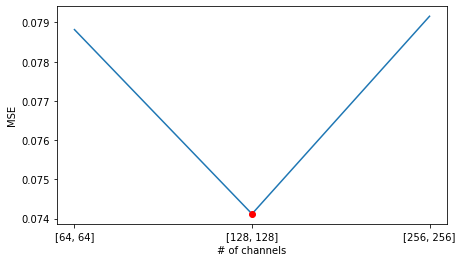

In [6]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(7,4))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels)), channels)
plt.xlabel('# of channels')
plt.ylabel('MSE')
plt.show()

In [7]:
channels_ = []
if channels[ind_min_ch][0]==64:
    channels_ = [[64, 64], [128, 64], [64, 128]]

elif channels[ind_min_ch][0]==128:
    channels_ = [[64, 128], [128, 64], [128, 128]]

else:
    channels_ = [[128, 256], [256, 128], [256, 256]]

channels_

[[64, 128], [128, 64], [128, 128]]

In [8]:
eta = 1e-3
lambda_reg = 0.0
#channels = [[64, 128], [128, 64], [128, 128]]
patience = 15
val_mse_channels = []

snn =  network.snn_1(input_dim=input_channels, hidden=hidden_neurons, n_classes=nr_freq,
                    timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

for ch in channels_:
    autoencoder_bipolar = network.cae_3(theta=0.5, kernel_size=3, 
                                        channels=ch, padding=1).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                optimizer, lambda_reg, epochs, patience, None)

    val_mse_channels.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [18:54<05:20, 29.10s/it]

Early stopping at epoch 39



 78%|███████▊  | 39/50 [18:44<05:17, 28.82s/it]

Early stopping at epoch 39


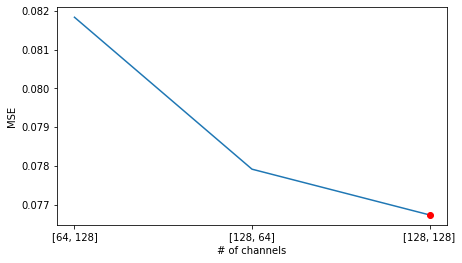

In [10]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(7,4))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels_)), channels_)
plt.xlabel('# of channels')
plt.ylabel('MSE')
plt.show()

### 3. Kernel size

In [11]:
eta = 1e-3
lambda_reg = 0.0
kernel_dic = {3: 1, 5: 2, 7: 3, 9: 4}
ch = channels_[ind_min_ch]
val_mse_kernel = []

snn =  network.snn_1(input_dim=input_channels, hidden=hidden_neurons, n_classes=nr_freq,
                    timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

for kernel, pad in kernel_dic.items():
    autoencoder_bipolar = network.cae_3(theta=0.5, kernel_size=kernel, 
                                        channels=ch, padding=pad).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_kernel.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [25:22<00:00, 30.44s/it]


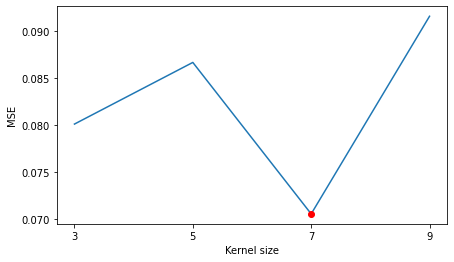

In [14]:
ind_min_ker = np.argmin(val_mse_kernel)
plt.figure(figsize=(7,4))
plt.plot(val_mse_kernel)
plt.plot(ind_min_ker, val_mse_kernel[ind_min_ker], marker='o', color='red')
plt.xticks(np.arange(len(kernel_dic)), kernel_dic.keys())
plt.xlabel('Kernel size')
plt.ylabel('MSE')
plt.show()

### 4. Threshold $\tau$

In [19]:
eta = 1e-3
lambda_reg = 0.0
theta_values = np.arange(0.1, 1.0, 0.2)
ch = [128, 128]
k = 7
val_mse_theta = []

for theta in theta_values:
    autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                        kernel_size=k, padding=kernel_dic[k]).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_theta.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [13:22<11:23, 29.73s/it]

Early stopping at epoch 27



100%|██████████| 50/50 [23:44<00:00, 28.50s/it]


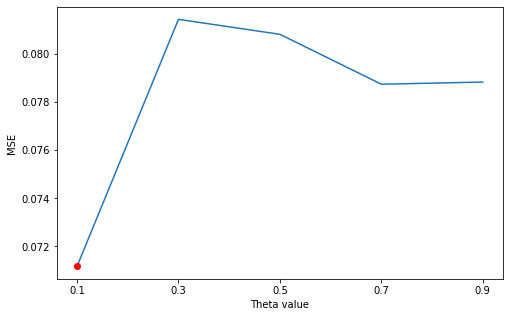

In [20]:
ind_min_theta = np.argmin(val_mse_theta)
plt.figure(figsize=(8,5))
plt.plot(theta_values, val_mse_theta)
plt.plot(theta_values[ind_min_theta], val_mse_theta[ind_min_theta], marker='o', color='red')
plt.xticks(theta_values)
plt.xlabel('Theta value')
plt.ylabel('MSE')
plt.show()

In [22]:
eta = 1e-3
lambda_reg = 0.0
theta_values = np.arange(0.05, 0.3, 0.05)
val_mse_theta = []

for theta in theta_values:
    autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                        kernel_size=k, padding=kernel_dic[k]).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                optimizer, lambda_reg, epochs, patience, None)

    val_mse_theta.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 40/50 [19:40<04:55, 29.52s/it]

Early stopping at epoch 40



 54%|█████▍    | 27/50 [13:30<11:30, 30.02s/it]

Early stopping at epoch 27



 70%|███████   | 35/50 [16:33<07:05, 28.39s/it]

Early stopping at epoch 35



100%|██████████| 50/50 [22:54<00:00, 27.48s/it]


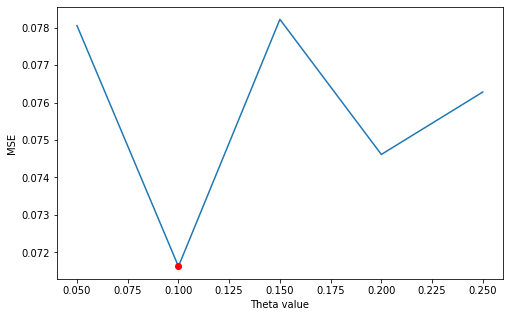

In [23]:
ind_min_theta = np.argmin(val_mse_theta)
plt.figure(figsize=(8,5))
plt.plot(theta_values, val_mse_theta)
plt.plot(theta_values[ind_min_theta], val_mse_theta[ind_min_theta], marker='o', color='red')
plt.xlabel('Theta value')
plt.ylabel('MSE')
plt.show()

### 5. Sparsity regularization

In [89]:
eta = 1e-3
theta = 0.1
lambda_reg = np.arange(0.0, 1.1, 0.1)
ch = [128, 128]
k = 7
epochs = 50

val_mse_reg = []
sparsity = []

snn =  network.snn_1(input_dim=input_channels, hidden=[128,64], n_classes=nr_freq,
                    timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

for lambda_ in lambda_reg:
    autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                        kernel_size=k, padding=kernel_dic[k]).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                optimizer, lambda_, epochs, patience, None)

    val_mse_reg.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

    net.eval()
    with torch.no_grad():
        spars = 0

        for X, _ in val_loader:
            X = X.to(device)
            spike = net(X.float())[0]
            spars += 1 - torch.mean(abs(spike))
        sparsity.append(spars.cpu().numpy()/len(val_loader))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [24:42<00:00, 29.66s/it]


In [92]:
metrics = pd.DataFrame({'Sparsity': sparsity, 'Error': val_mse_reg})

display(metrics)

,Sparsity,Error
0,0.051448,0.093566
1,0.486021,0.070775
2,0.722474,0.073270
3,0.688738,0.094218
4,0.739068,0.073925
5,0.809359,0.094245
6,0.801681,0.084794
7,0.710692,0.097826
8,0.738224,0.100411
9,0.827679,0.096095


In [93]:
metrics.to_csv('Sparsity_vs_error1.csv')

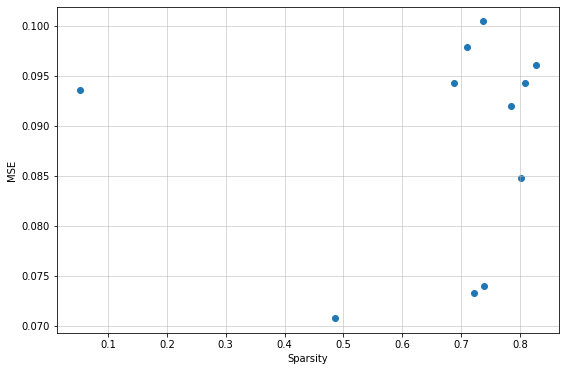

In [90]:
plt.figure(figsize=(9,6))

ind_min_reg = np.argmin(val_mse_reg)
plt.scatter(sparsity, val_mse_reg)
#plt.plot(lambda_reg[ind_min_reg], val_mse_reg[ind_min_reg], marker='o', color='red')
plt.grid(alpha=0.6)
plt.xlabel('Sparsity')
plt.ylabel('MSE')

plt.show()

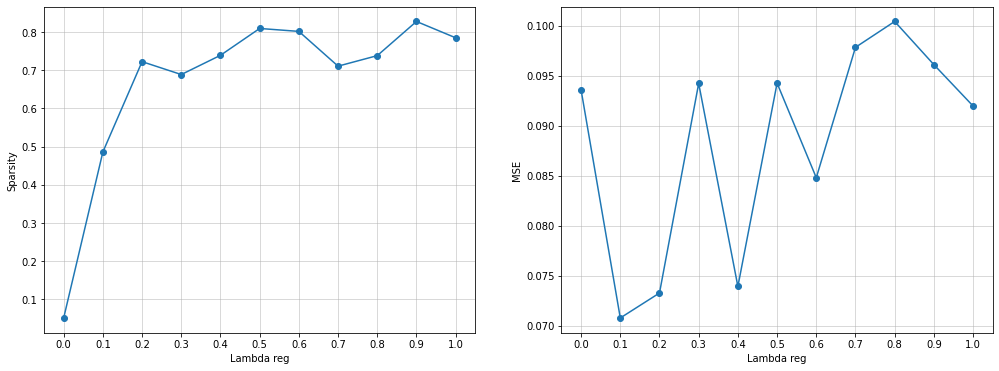

In [91]:
plt.subplots(1,2, figsize=(17,6))

plt.subplot(121)
ind_min_reg = np.argmin(val_mse_reg)
plt.plot(lambda_reg, sparsity, marker='o')
plt.xticks(lambda_reg)
plt.grid(alpha=0.6)
plt.xlabel('Lambda reg')
plt.ylabel('Sparsity')

plt.subplot(122)
plt.plot(lambda_reg, val_mse_reg, marker='o')
plt.xticks(lambda_reg)
plt.grid(alpha=0.6)
plt.xlabel('Lambda reg')
plt.ylabel('MSE')

plt.show()

### 6. Learning rate $\eta$

In [69]:
theta = 0.1
lambda_reg = 0.2
ch = [128, 128]

learning_rates = [1e-4, 1e-3, 1e-2]
mse_values_lr = []

for eta in learning_rates:
    autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                        kernel_size=k, padding=kernel_dic[k]).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    mse_values_lr.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [26:32<01:41, 33.88s/it]

Early stopping at epoch 47



 76%|███████▌  | 38/50 [18:46<05:55, 29.64s/it]

Early stopping at epoch 38


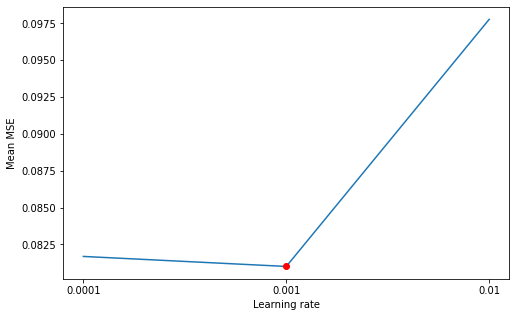

In [70]:
ind_min_lr = np.argmin(mse_values_lr)
plt.figure(figsize=(8,5))
plt.plot(mse_values_lr)
plt.plot(ind_min_lr,  mse_values_lr[ind_min_lr], marker='o', color='red')
plt.xticks([0, 1, 2], learning_rates)
plt.xlabel('Learning rate')
plt.ylabel('Mean MSE')
plt.show()

### 7. Optimization algorithm

In [73]:
eta = 1e-3
theta = 0.9
lambda_reg = 0.2

mse_values_opt = []

autoencoder_bipolar = network.cae_3(theta=theta, kernel_size=7, 
                                                channels=[128, 256], padding=3).to(device)

net = LSE(autoencoder_bipolar, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

mse_values_opt.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

################################################################################################

optimizer = torch.optim.SGD(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

mse_values_opt.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

100%|██████████| 25/25 [11:53<00:00, 28.56s/it]


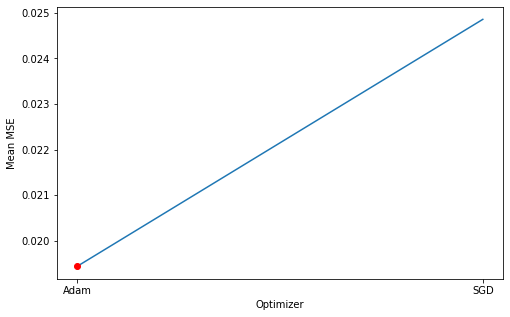

In [74]:
ind_min_opt = np.argmin(mse_values_opt)
plt.figure(figsize=(8,5))
plt.plot(mse_values_opt)
plt.plot(ind_min_opt,  mse_values_opt[ind_min_opt], marker='o', color='red')
plt.xticks([0, 1], ['Adam', 'SGD'])
plt.xlabel('Optimizer')
plt.ylabel('Mean MSE')
plt.show()

### 8. Number of SNN layers

In [71]:
eta = learning_rates[ind_min_lr]
theta = 0.1
lambda_reg = 0.2

input_channels = 2
hidden_neurons = [64, 64, 64]
num_steps = 64
nr_freq = 5
surr_gradient = surrogate.atan()

val_mse_snn_layers = []

autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)

###########################################################################################
# 2 hidden layers
###########################################################################################
snn =  network.snn_1(input_dim=input_channels, hidden=hidden_neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surr_gradient, learn_thr=True).to(device)

net = LSE(autoencoder_bipolar, snn).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

val_mse_snn_layers.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

###########################################################################################
# 3 hidden layers
###########################################################################################
snn =  network.snn_2(input_dim=input_channels, hidden=hidden_neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surr_gradient, learn_thr=True).to(device)
    
net = LSE(autoencoder_bipolar, snn).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

val_mse_snn_layers.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [30:16<00:00, 36.34s/it]


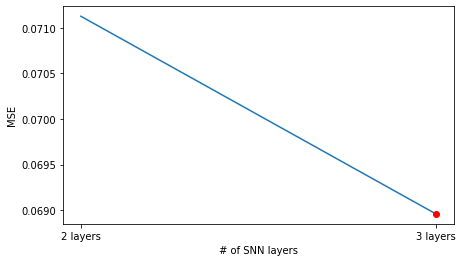

In [72]:
ind_min_nls = np.argmin(val_mse_snn_layers)
plt.figure(figsize=(7,4))
plt.plot(val_mse_snn_layers)
plt.plot(ind_min_nls, val_mse_snn_layers[ind_min_nls], marker='o', color='red')
plt.xticks([0, 1], ['2 layers', '3 layers'])
plt.xlabel('# of SNN layers')
plt.ylabel('MSE')
plt.show()

### 9. Number of LIF neurons

In [74]:
input_channels = 2
hidden_neurons = [[64, 64], [128, 128], [256, 256]]
num_steps = 64
nr_freq = 5
val_mse_neurons = []

autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


for neurons in hidden_neurons:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                        timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)
    
    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_neurons.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [17:14<08:52, 31.34s/it]

Early stopping at epoch 33


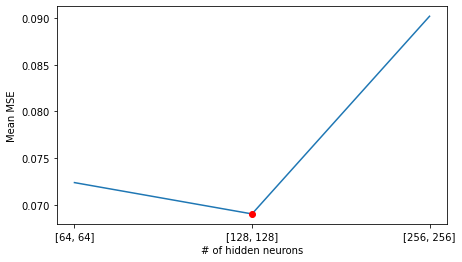

In [75]:
ind_min_neurons = np.argmin(val_mse_neurons)
plt.figure(figsize=(7,4))
plt.plot(val_mse_neurons)
plt.plot(ind_min_neurons, val_mse_neurons[ind_min_neurons], marker='o', color='red')
plt.xticks([0, 1, 2], ['[64, 64]', '[128, 128]', '[256, 256]'])
plt.xlabel('# of hidden neurons')
plt.ylabel('Mean MSE')
plt.show()

In [77]:
input_channels = 2
hidden_neurons = [[128, 64], [64, 128], [128, 128]]
num_steps = 64
nr_freq = 5

val_mse_neurons = []

autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


for neurons in hidden_neurons:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_neurons.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 35/50 [25:32<10:56, 43.79s/it]

Early stopping at epoch 35


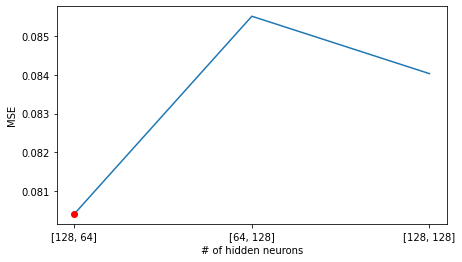

In [78]:
ind_min_neurons = np.argmin(val_mse_neurons)
plt.figure(figsize=(7,4))
plt.plot(val_mse_neurons)
plt.plot(ind_min_neurons, val_mse_neurons[ind_min_neurons], marker='o', color='red')
plt.xticks([0, 1, 2], hidden_neurons)
plt.xlabel('# of hidden neurons')
plt.ylabel('MSE')
plt.show()

### 10. Surrogate gradient

In [83]:
neurons = hidden_neurons[ind_min_neurons]
surr_gradients = [surrogate.atan(), surrogate.fast_sigmoid(), 
                  surrogate.straight_through_estimator()]

val_mse_surr = []

autoencoder_bipolar = network.cae_3(theta=theta, kernel_size=7, 
                                            channels=[128, 256], padding=3).to(device)


for surr_grad in surr_gradients:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surr_grad, learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

    val_mse_surr.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [09:19<00:00, 22.40s/it]


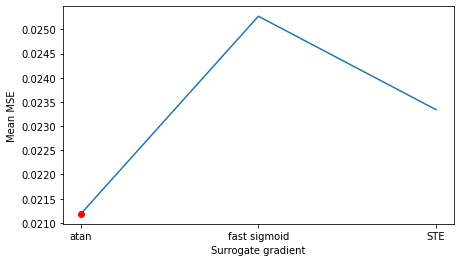

In [84]:
ind_min_surr = np.argmin(val_mse_surr)
plt.figure(figsize=(7,4))
plt.plot(val_mse_surr)
plt.plot(ind_min_surr, val_mse_surr[ind_min_surr], marker='o', color='red')
plt.xticks([0, 1, 2], ['atan', 'fast sigmoid', 'STE'])
plt.xlabel('Surrogate gradient')
plt.ylabel('Mean MSE')
plt.show()

### Train with optimized hyperparams

In [11]:
kernel_dic = {3: 1, 5: 2, 7: 3, 9: 4}
k = 7
theta = 0.1
lambda_reg = 0.2

input_channels = 2
nr_freq = 5
num_steps = 64

eta = 1e-3
patience = 45
epochs = 150
path = "models/net_new1_lambda_0.2.pt"


autoencoder_bipolar = network.cae_3(theta=theta, channels=[128, 128],  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


snn =  network.snn_1(input_dim=input_channels, hidden= [128, 64], n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

net = LSE(autoencoder_bipolar, snn).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss_list, val_loss_list = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                       optimizer, lambda_reg, epochs, patience, None)

  0%|          | 0/150 [00:00<?, ?it/s]

 81%|████████▏ | 122/150 [59:17<13:36, 29.16s/it] 

Early stopping at epoch 122


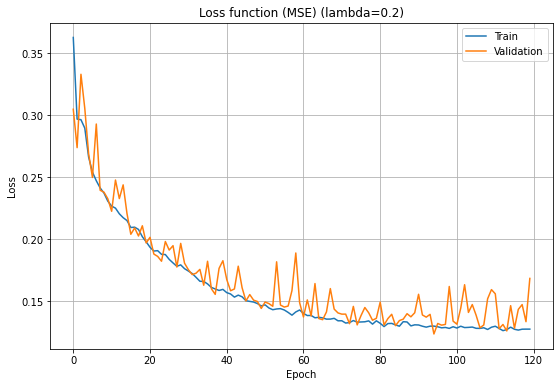

In [85]:
plt.figure(figsize=(9, 6))
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Loss function (MSE) (lambda={lambda_reg})")
plt.show()